### Kaustav Vats (2016048)

In [ ]:
import numpy as np
import sys
import copy
from apyori import create_next_candidates, TransactionManager
from itertools import combinations
from tqdm import tqdm_notebook as tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline 
# Reference
# https://github.com/ymoch/apyori/blob/master/apyori.py
# https://www.geeksforgeeks.org/itertools-combinations-module-python-print-possible-combinations/

In [18]:
def LoadData(filename):
    d = []
    f = open("Data/" + filename, 'r')
    for line in f:
        if line == "":
            break
        d.append(list(map(int, line.split("\n")[0].split())))
    return d

def GetMax(data):
    maxi = -1
    mini = sys.maxsize
    for t in data:
        maxi2 = max(t)
        mini2 = min(t)
        if maxi2 > maxi:
            maxi = maxi2
        if mini2 < mini:
            mini = mini2
    return maxi, mini

def GetSupport(N, data, mini, maxi):
    s = {}
    for i in range(N):
        for j in range(len(data[i])):
            if data[i][j] in s:
                s[data[i][j]] += 1
            else:
                s[data[i][j]] = 1
    Brr = []
    for k in s:
        Brr.append(s[k]/N)
    return Brr

def GetC1(s, min_supp):
    c1 = copy.deepcopy(s)
    for k in s:
        if c1[k] < min_supp:
            del c1[k]
    return c1

def SortDictionary(dic):
    ndic = {}
    l = sorted(dic.items(), key=lambda kv: kv[1])
    for e in l:
        ndic[e[0]] = e[1]
    return ndic

def calc_hconf(item_set, items_support, support):
    Arr = []
    for item in item_set:
        Arr.append(items_support[item])
    return support/max(Arr)

def PruneB(ItemSet, hc, item_support):
    Ll = list(ItemSet)
    Arr = []
    for i in range(len(Ll)):
        Arr.append(item_support[Ll[i]])
    if hc > min(Arr)/max(Arr):
        return True
    else:
        return False

def HyperCliqueAlgo(Data):
    Result = []
    tManager = TransactionManager.create(Data)
    Candidates = tManager.initial_candidates()
    ItemSupport = {}
    for ItemSet in Candidates:
        ll = list(ItemSet)[0]
        ItemSupport[ll] = tManager.calc_support(ItemSet)
    
    PrevCandidates = Candidates
    size = 1
    
    # Step-1
    relations = set()
    for ItemSet in Candidates:
        support = tManager.calc_support(ItemSet)
        if support < min_supp:
            continue
        candidate_set = frozenset(ItemSet)
        relations.add(candidate_set)
    size += 1
    Candidates = create_next_candidates(relations, size)
    
    # Below code contains step-2 to 4
    while Candidates:
        relations = set()
        for ItemSet in Candidates:
            support = tManager.calc_support(ItemSet)
            hconf = calc_hconf(ItemSet, ItemSupport, support)

            # Prune A
            Subsets = list(combinations(ItemSet, size-1)) 
            Flag = False
            for sub in Subsets:
                if frozenset(sub) not in PrevCandidates:
                    Flag = True
                    break
            if Flag:
                continue
                    
            # Prune B
            if PruneB(ItemSet, hconf, ItemSupport):
                continue
            
            # Prune C
            if support < min_supp or hconf < min_hc:
                continue
            
            candidate_set = frozenset(ItemSet)
            relations.add(candidate_set)
#             print(candidate_set)
            Result.append(candidate_set)
        size += 1
        if size > (MaxEl-MinEl):
            break
        PrevCandidates = Candidates
        Candidates = create_next_candidates(relations, size)
    return Result

In [19]:
Data = LoadData("retail.dat")
N = len(Data)
MaxEl, MinEl = GetMax(Data)
print(MaxEl, MinEl)

16469 0


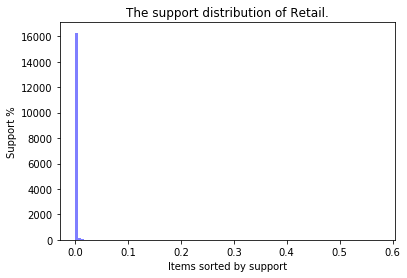

In [30]:
SupportList = GetSupport(N, Data, MinEl, MaxEl)
num_bins = 100
plt.figure()
n, bins, patches = plt.hist(SupportList, num_bins, facecolor='blue', alpha=0.5)
plt.title("The support distribution of Retail.")
plt.xlabel("Items sorted by support")
plt.ylabel("Support %")
plt.show()

In [13]:
MinSupList = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
MinHcList = [0.1, 0.2, 0.5, 0.7, 0.9]
Results = []
Times = []
for min_hc in tqdm(MinHcList):
    temp = []
    temp_time = []
    for min_supp in MinSupList:
        start_time = time.time()
        Result = HyperCliqueAlgo(Data)
        temp_time.append(time.time()-start_time)
        temp.append(len(Result))
    Results.append(temp)
    Times.append(temp_time)
print(Results)
print(Times)

[[16, 10, 4, 1, 1, 1, 1, 0, 0, 0], [6, 4, 4, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[2.408465623855591, 1.401245355606079, 1.187626838684082, 1.4437475204467773, 1.1276204586029053, 1.1161527633666992, 1.277381420135498, 1.0199761390686035, 1.0636694431304932, 1.1994824409484863], [1.9157366752624512, 1.1169145107269287, 1.2131078243255615, 1.0794496536254883, 1.0393319129943848, 1.1609578132629395, 1.077089548110962, 1.3071787357330322, 1.1067523956298828, 1.0605278015136719], [2.103090286254883, 1.3723106384277344, 1.3253343105316162, 1.332965612411499, 1.0867412090301514, 1.1675457954406738, 1.2250704765319824, 1.049433708190918, 1.0422759056091309, 1.0665299892425537], [1.9144079685211182, 1.2988903522491455, 1.0700619220733643, 1.0667970180511475, 1.2200422286987305, 0.9793014526367188, 1.1098225116729736, 1.252004623413086, 1.0624725818634033, 1.0505948066711426], [2.102369546890259, 1.122342109680175

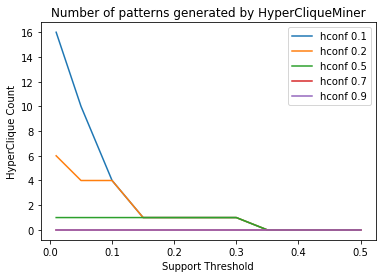

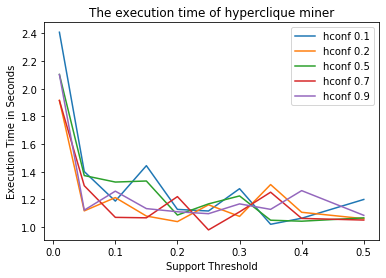

In [14]:
def HyperCliqueCountGraphs():
    plt.figure()
    for i in range(len(Results)):
        plt.plot(MinSupList, Results[i], label="hconf {}".format(str(MinHcList[i])))
    plt.title('Number of patterns generated by HyperCliqueMiner')
    plt.ylabel('HyperClique Count')
    plt.xlabel('Support Threshold')
    plt.legend()
    plt.show()
    
def HyperCliqueTimeGraph():
    plt.figure()
    for i in range(len(Results)):
        plt.plot(MinSupList, Times[i], label="hconf {}".format(str(MinHcList[i])))
    plt.title('The execution time of hyperclique miner')
    plt.ylabel('Execution Time in Seconds')
    plt.xlabel('Support Threshold')
    plt.legend()
    plt.show()

def DataSizeTime(Time, Size):
    plt.figure()
    plt.plot(Size, Time, label="hconf {} | min_supp {}".format(str(min_hc), str(min_supp)))
    plt.title('Effect of execution of algorithm on no of transactions')
    plt.ylabel('Execution Time in Seconds')
    plt.xlabel('Considering x% of Transactions in data')
    plt.legend()
    plt.show()
    
HyperCliqueCountGraphs()
HyperCliqueTimeGraph()

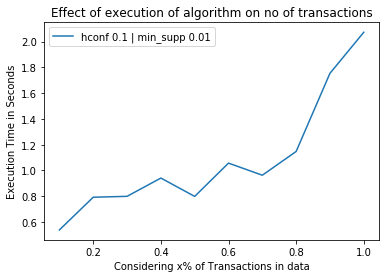

In [15]:
#Execution time for Different size of the data
Size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
Data = LoadData("retail.dat")
min_hc = 0.1
min_supp = 0.01
temp_time = []
for dSize in Size:
    D = Data[:int(len(Data)*dSize)]
    MaxEl, MinEl = GetMax(D)
    start_time = time.time()
    Result = HyperCliqueAlgo(D)
    temp_time.append(time.time()-start_time)

DataSizeTime(temp_time, Size)